In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter('ignore')

10個の観測項目を1つのテーブルにまとめる．

In [55]:
path = os.path.join(os.path.dirname(os.getcwd()),'01-JMA_data_analytics','data')
df = None

for file in os.listdir(path):
    if file.endswith('.csv'):
        file_name = file.replace('.csv','')
        if file in ['daylight.csv','precipitation.csv']:
            skiprows, usecols = 4, [0,1]
            columns = ['datetime', file_name]
        elif file in ['wind.csv']:
            skiprows, usecols = 4, [0,1,2]
            columns = ['datetime', 'speed', 'direction']
        else:
            skiprows, usecols = 3, [0,1]
            columns = ['datetime', file_name]
        tmp = pd.read_csv(os.path.join(path,file), encoding='shift-jis', skiprows=skiprows, usecols=usecols)
        tmp.columns = columns
        tmp['datetime'] = pd.to_datetime(tmp['datetime'])

        if df is None:
            df = tmp
        else:
            df = pd.merge(df, tmp, on='datetime', how='outer')

In [56]:
# nanのある行を削除
df = df.dropna()

# weatherをOne-hotエンコーディング
df['weather'] = df['weather'].map({2:'sun',4:'cloudy',10:'rain',11:'sleet',12:'snow'})
df = pd.concat([df.drop(['weather'], axis=1), pd.get_dummies(df['weather']).astype(int)], axis=1)

# speed,directionをベクトルに変換
directions = {'北':90,'北北東':90*(3/4),'北北西':90*(5/4),'北東':90*(2/4),'北西':90*(6/4),'南':-90,'南南東':-90*(3/4),'南南西':-90*(5/4),'南東':-90*(2/4),'南西':-90*(6/4),'東':0,'東北東':90*(1/4),'東南東':-90*(1/4),'西':180,'西北西':90*(7/4),'西南西':-90*(7/4),'静穏':None}
directions_x = {k:np.cos(np.deg2rad(v)) if k!='静穏' else 0 for k,v in directions.items()}
directions_y = {k:np.sin(np.deg2rad(v)) if k!='静穏' else 0 for k,v in directions.items()}
df['direction_x'] = df['direction'].map(directions_x)
df['direction_y'] = df['direction'].map(directions_y)
df['wind_x'] = df['speed'] * df['direction_x']
df['wind_y'] = df['speed'] * df['direction_y']
df.drop(['direction','direction_x','direction_y'], axis=1, inplace=True)

# ラグ特徴量を追加
cols = df.columns[1:]
for i in range(1,10):
    for col in cols:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

In [57]:
df_original = df.copy()

In [65]:
df_original.shape

(8780, 151)

### 気温の検証（ME，RMSE）

In [67]:
df = df_original.copy()
df['target'] = df['temperature'].shift(-24)  # Predict 24 hours ahead
df = df.dropna()

TRAIN: 6997 TEST: 1750


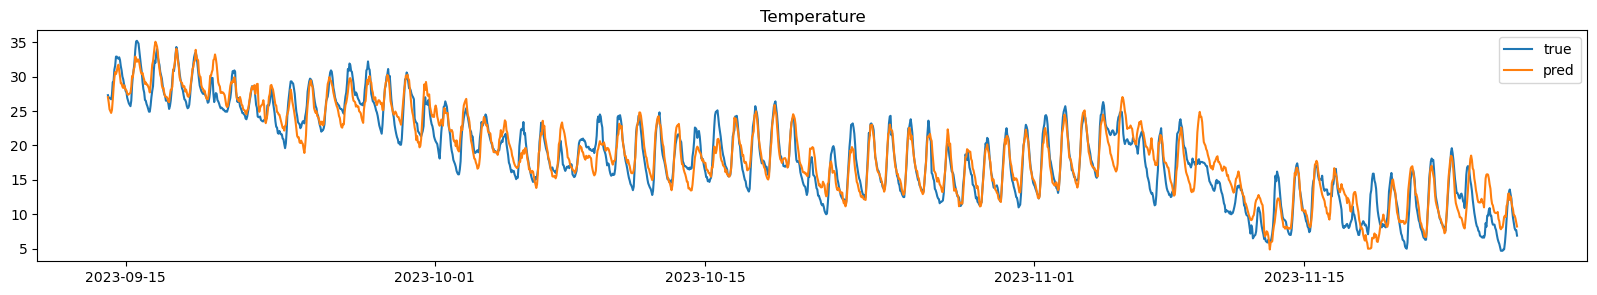

In [68]:
# Train-Test Split
N_train = int(len(df)*0.8)
print('TRAIN:', N_train, 'TEST:', len(df)-N_train)
X_train, X_test = df.iloc[:N_train].drop(['datetime','target'],axis=1), df.iloc[N_train:].drop(['datetime','target'],axis=1)
y_train, y_test = df.iloc[:N_train]['target'], df.iloc[N_train:]['target']

# Normalization
mu = X_train.mean()
sigma = X_train.std()
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Training and Prediction
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Plot
plt.figure(figsize=(20,3))
plt.plot(df.iloc[N_train:]['datetime'], y_test, label='true')
plt.plot(df.iloc[N_train:]['datetime'], y_pred, label='pred')
plt.legend()
plt.title('Temperature')
plt.show()

In [60]:
df_pred = pd.DataFrame({'datetime':df.iloc[N_train:]['datetime'].values, 'true':y_test.values, 'pred':y_pred})
df_maxmin = df_pred.groupby(df_pred['datetime'].dt.date, as_index=False).agg({'pred':['max','min'], 'true':['max','min']})

# 最高気温
error_max = df_maxmin['pred']['max'] - df_maxmin['true']['max']
print('Highest Temperature')
print(f"- ME   : {error_max.mean()}")
print(f"- RMSE : {error_max.pow(2).mean()**0.5}")

# 最低気温
error_min = df_maxmin['pred']['min'] - df_maxmin['true']['min']
print('Lowest Temperature')
print(f"- ME   : {error_min.mean()}")
print(f"- RMSE : {error_min.pow(2).mean()**0.5}")

Highest Temperature
- ME   : -0.2472207344355263
- RMSE : 2.1101543396002227
Lowest Temperature
- ME   : 0.6470339790754622
- RMSE : 2.0555428536482445


### 降水の検証
- 適中率
- 見逃し率
- 空振り率
- 補足率
- 一致率

In [69]:
df = df_original.copy()

# create label
precip_day = df.groupby(df['datetime'].dt.date)['precipitation'].sum()
label_map = dict((precip_day > 1).astype(int))
df['target'] = df['datetime'].dt.date.map(label_map)

df['target'] = df['target'].shift(-24)  # Predict 24 hours ahead

df = df.dropna()

TRAIN: 6997 TEST: 1750


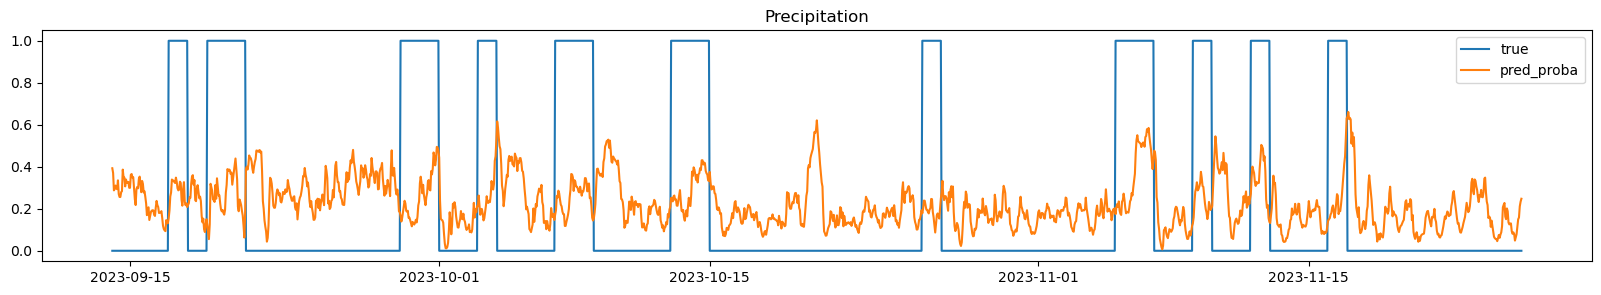

In [70]:
# Train-Test Split
N_train = int(len(df)*0.8)
print('TRAIN:', N_train, 'TEST:', len(df)-N_train)
X_train, X_test = df.iloc[:N_train].drop(['datetime','target'],axis=1), df.iloc[N_train:].drop(['datetime','target'],axis=1)
y_train, y_test = df.iloc[:N_train]['target'], df.iloc[N_train:]['target']

# Normalization
mu = X_train.mean()
sigma = X_train.std()
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Training and Prediction
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Plot
plt.figure(figsize=(20,3))
plt.plot(df.iloc[N_train:]['datetime'], y_test, label='true')
plt.plot(df.iloc[N_train:]['datetime'], y_pred_proba, label='pred_proba')
plt.legend()
plt.title('Precipitation')
plt.show()

In [78]:
df_pred = pd.DataFrame({'datetime':df.iloc[N_train:]['datetime'].values, 'true':y_test.values, 'pred':y_pred_proba})
df_pred = df_pred.groupby(df_pred['datetime'].dt.date, as_index=False)[['pred','true']].mean()

threshold = 0.5
y_pred = (df_pred['pred'] > threshold).astype(int)
y_true = df_pred['true'].astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
A, B, C, D = cm.ravel()
print(cm)

# 適中率（降水の有無）
print(f"適中率（降水の有無）: {(A+D)/(A+B+C+D)*100:.2f}%")
# 「降水あり」予報の適中率
print(f"「降水あり」予報の適中率: {D/(B+D)*100:.2f}%")
# 「降水なし」予報の適中率
print(f"「降水なし」予報の適中率: {A/(A+C)*100:.2f}%")
# 見逃し率
print(f"見逃し率: {C/(A+B+C+D)*100:.2f}%")
# 空振り率
print(f"空振り率: {B/(A+B+C+D)*100:.2f}%")
# 捕捉率
print(f"捕捉率: {D/(C+D)*100:.2f}%")

# スレットスコア
print(f"スレットスコア: {D/(B+C+D):.2f}")
# バイアススコア
print(f"バイアススコア: {(B+D)/(C+D):.2f}")

# ブライアスコア
print(f"ブライアスコア: {(df_pred['pred']-df_pred['true']).pow(2).mean():.2f}")

[[58  0]
 [15  1]]
適中率（降水の有無）: 79.73%
「降水あり」予報の適中率: 100.00%
「降水なし」予報の適中率: 79.45%
見逃し率: 20.27%
空振り率: 0.00%
捕捉率: 6.25%
スレットスコア: 0.06
バイアススコア: 0.06
ブライアスコア: 0.16
